In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Fuzzy Set Project/diabetes.csv")
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
cols_with_zero_invalid = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in cols_with_zero_invalid:
    if c in df.columns:
        med = df.loc[df[c] != 0, c].median()
        df.loc[df[c] == 0, c] = med

In [5]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_norm = X / X.max()
X_norm = X_norm.fillna(0)
X_norm
y

,Outcome
0,1
1,0
2,1
3,0
4,1
...,...
763,0
764,0
765,0
766,1


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.48, stratify=y, random_state=42)

A0 = X_train[y_train==0].to_numpy()
A1 = X_train[y_train==1].to_numpy()

print("Train size:", X_train.shape, "Test size:", X_test.shape)
A1

Train size: (399, 8) Test size: (369, 8)


array([[0.        , 0.90954774, 0.72131148, ..., 0.64530551, 0.09173554,
        0.32098765],
       [0.41176471, 0.50251256, 0.59016393, ..., 0.44709389, 0.2       ,
        0.39506173],
       [0.47058824, 0.94472362, 0.63934426, ..., 0.71385991, 0.05661157,
        0.5308642 ],
       ...,
       [0.76470588, 0.7638191 , 0.73770492, ..., 0.39940387, 0.30206612,
        0.5308642 ],
       [0.47058824, 0.54271357, 0.57377049, ..., 0.45454545, 0.3946281 ,
        0.40740741],
       [0.05882353, 0.81909548, 0.59016393, ..., 0.58122206, 0.50495868,
        0.40740741]])

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def dist_matrix(A, B):
    return np.linalg.norm(A[:,None,:] - B[None,:,:], axis=2)

D = dist_matrix(A0, A1)

p, q = np.unravel_index(np.argmax(D), D.shape)
x_p = A0[p]
y_q = A1[q]
def cosine_amplitude(A, x):
    A_norm = np.linalg.norm(A, axis=1)
    x_norm = np.linalg.norm(x)
    A_norm[A_norm == 0] = 1e-9
    if x_norm == 0: x_norm = 1e-9
    return (A @ x) / (A_norm * x_norm)

# Classifier-1 similarity
U0 = cosine_amplitude(A0, x_p)
U1 = cosine_amplitude(A1, x_p)

# Normalize (Eq.6-9)
U0_hat = U0 / U0.sum()
U1_hat = U1 / U1.sum()

# Classifier-2 similarity
V0 = cosine_amplitude(A0, y_q)
V1 = cosine_amplitude(A1, y_q)

V0_hat = V0 / V0.sum()
V1_hat = V1 / V1.sum()

# 6. Histogram fuzzy sets (h0, h1, l0, l1)

def fuzzy_hist(vals, bins=50):
    hist, edges = np.histogram(vals, bins=bins, density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    hist = hist / hist.max() if hist.max()!=0 else hist
    return centers, hist

cent_U1, hist_U1 = fuzzy_hist(U1)
cent_V0, hist_V0 = fuzzy_hist(V0)


# 7. ̸-cuts (selecting thresholds from histogram)

def lambda_cut(centers, hist, percentile=85):
    nz = centers[hist > 0]
    if len(nz)==0: return centers.mean()
    return np.percentile(nz, percentile)

lam_h1 = lambda_cut(cent_U1, hist_U1, 85)
lam_l0 = lambda_cut(cent_V0, hist_V0, 85)


# 8. Test-time similarity & fuzzy membership check

def cosine_test(X, ref):
    norms = np.linalg.norm(X, axis=1)
    ref_norm = np.linalg.norm(ref)
    norms[norms==0] = 1e-9
    if ref_norm==0: ref_norm = 1e-9
    return (X @ ref) / (norms * ref_norm)

test_U = cosine_test(X_test, x_p)
test_V = cosine_test(X_test, y_q)

# ----------------------------------------------------------
# 9. Convert similarity to fuzzy membership via histogram
# ----------------------------------------------------------
def membership(value, centers, hist):
    return np.interp(value, centers, hist, left=0, right=0)

y_pred = []

for u, v in zip(test_U, test_V):

    mem_h1 = membership(u, cent_U1, hist_U1)   # diabetic membership
    mem_l0 = membership(v, cent_V0, hist_V0)   # healthy membership

    # Rule 1 (Classifier-1)
    if u >= lam_h1:
        y_pred.append(1)
        continue

    # Rule 2 (Classifier-2)
    if v <= lam_l0:
        y_pred.append(0)
        continue

    # fallback: whichever has greater fuzzy membership
    y_pred.append(1 if mem_h1 >= mem_l0 else 0)

y_pred = np.array(y_pred)

# 10. Evaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n========== Final Results (Paper Model) ==========")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)


========== Final Results (Paper Model) ==========
Accuracy: 0.6395663956639567
Precision: 0.46153846153846156
Recall: 0.18604651162790697
F1-score: 0.26519337016574585


In [45]:
from sklearn.metrics import classification_report

print("========== Fuzzy Classifier (Paper Model) Classification Report ==========")
print(classification_report(y_test, y_pred))

========== Fuzzy Classifier (Paper Model) Classification Report ==========
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       240
           1       0.46      0.19      0.27       129

    accuracy                           0.64       369
   macro avg       0.57      0.53      0.51       369
weighted avg       0.60      0.64      0.59       369



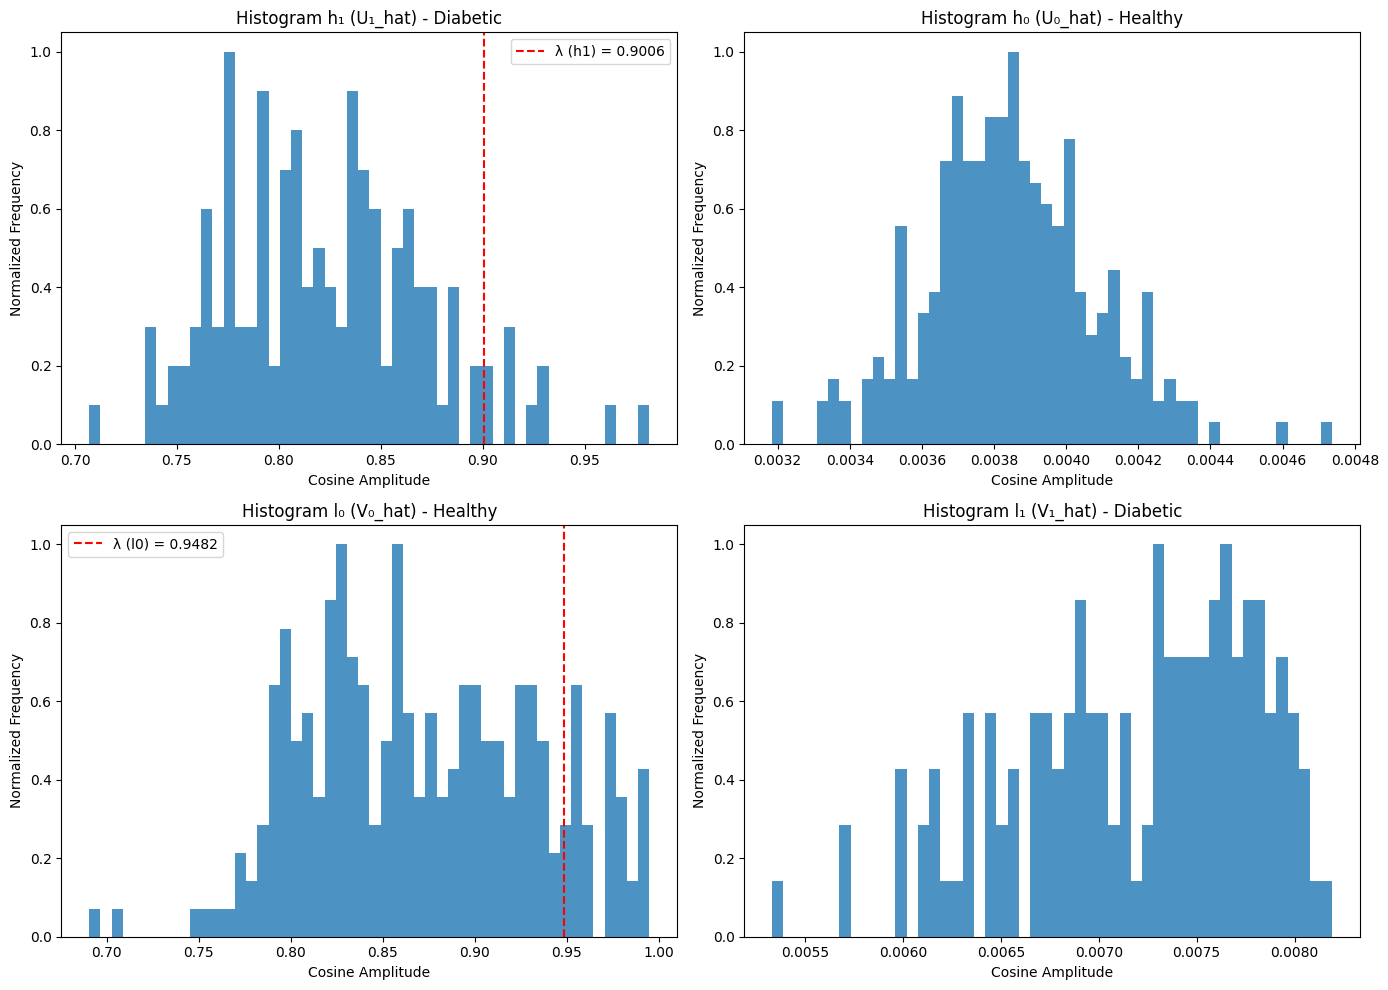

In [8]:
# ==========================================================
# Visualization 1: Histogram Fuzzy Sets
# ==========================================================

plt.figure(figsize=(14,10))

# h1 (U1_hat - diabetic)
plt.subplot(2,2,1)
plt.bar(cent_U1, hist_U1, width=(cent_U1[1]-cent_U1[0]), alpha=0.8)
plt.axvline(lam_h1, color='red', linestyle='--', label=f"λ (h1) = {lam_h1:.4f}")
plt.title("Histogram h₁ (U₁_hat) - Diabetic")
plt.xlabel("Cosine Amplitude")
plt.ylabel("Normalized Frequency")
plt.legend()

# h0 (U0_hat - healthy)
cent_U0, hist_U0 = fuzzy_hist(U0_hat)
plt.subplot(2,2,2)
plt.bar(cent_U0, hist_U0, width=(cent_U0[1]-cent_U0[0]), alpha=0.8)
plt.title("Histogram h₀ (U₀_hat) - Healthy")
plt.xlabel("Cosine Amplitude")
plt.ylabel("Normalized Frequency")

# l0 (V0_hat - healthy)
plt.subplot(2,2,3)
plt.bar(cent_V0, hist_V0, width=(cent_V0[1]-cent_V0[0]), alpha=0.8)
plt.axvline(lam_l0, color='red', linestyle='--', label=f"λ (l0) = {lam_l0:.4f}")
plt.title("Histogram l₀ (V₀_hat) - Healthy")
plt.xlabel("Cosine Amplitude")
plt.ylabel("Normalized Frequency")
plt.legend()

# l1 (V1_hat - diabetic)
cent_V1, hist_V1 = fuzzy_hist(V1_hat)
plt.subplot(2,2,4)
plt.bar(cent_V1, hist_V1, width=(cent_V1[1]-cent_V1[0]), alpha=0.8)
plt.title("Histogram l₁ (V₁_hat) - Diabetic")
plt.xlabel("Cosine Amplitude")
plt.ylabel("Normalized Frequency")

plt.tight_layout()
plt.show()


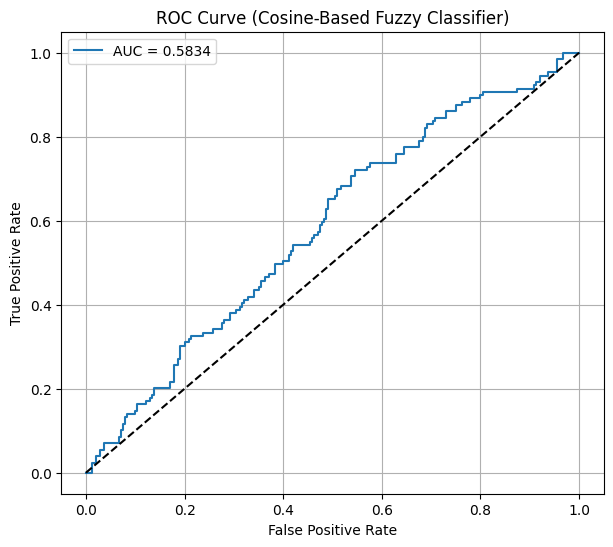

In [9]:
# ==========================================================
# Visualization 2: ROC Curve
# ==========================================================

from sklearn.metrics import roc_curve, auc

# Combined score = max(test_U, test_V)
combined_score = np.maximum(test_U, test_V)

fpr, tpr, _ = roc_curve(y_test, combined_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Cosine-Based Fuzzy Classifier)")
plt.legend()
plt.grid(True)
plt.show()


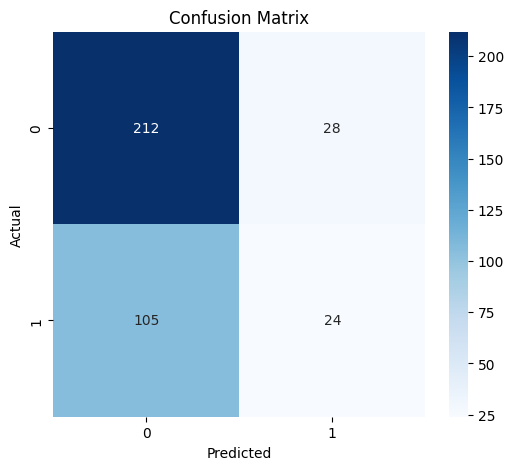

In [10]:
# ==========================================================
# Visualization 3: Confusion Matrix Heatmap
# ==========================================================

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [14]:
import numpy as np
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pygad
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.48, stratify=y, random_state=42)
n_features = X_train.shape[1]
n_mf = 3
mf_type = 'gauss'
param_per_mf = 2
total_params = n_features * n_mf * param_per_mf
def evaluate_fis(params):
    params = np.array(params)
    params = params.reshape((n_features, n_mf, param_per_mf))
    fuzzy_outputs = []
    for i, x in enumerate(X_train.to_numpy()):
        memberships = []
        for f in range(n_features):
            mfs = []
            for j in range(n_mf):
                c, s = params[f, j]
                mf_value = np.exp(-0.5 * ((x[f] - c) / (s + 1e-6)) ** 2)
                mfs.append(mf_value)
            memberships.append(max(mfs))
        fuzzy_outputs.append(np.mean(memberships))
    preds = (np.array(fuzzy_outputs) > np.mean(fuzzy_outputs)).astype(int)
    acc = accuracy_score(y_train, preds)
    return acc
def fitness_func(ga_instance, solution, solution_idx):
    acc = evaluate_fis(solution)
    return acc
ga_instance = pygad.GA(num_generations=50,
                       num_parents_mating=8,
                       fitness_func=fitness_func,
                       sol_per_pop=20,
                       num_genes=total_params,
                       mutation_probability=0.1,
                       mutation_percent_genes=10,
                       gene_space={'low':0, 'high':1},
                       parent_selection_type="rank",
                       keep_parents=2)

ga_instance.run()
best_solution, best_fitness, _ = ga_instance.best_solution()
print(f"Best training accuracy after GA tuning: {best_fitness:.4f}")
def evaluate_on_test(params):
    params = np.array(params).reshape((n_features, n_mf, param_per_mf))
    fuzzy_outputs = []
    for x in X_test.to_numpy():
        memberships = []
        for f in range(n_features):
            mfs = []
            for j in range(n_mf):
                c, s = params[f, j]
                mf_value = np.exp(-0.5 * ((x[f] - c) / (s + 1e-6)) ** 2)
                mfs.append(mf_value)
            memberships.append(max(mfs))
        fuzzy_outputs.append(np.mean(memberships))
    preds = (np.array(fuzzy_outputs) > np.mean(fuzzy_outputs)).astype(int)
    return accuracy_score(y_test, preds)

test_acc = evaluate_on_test(best_solution)
print(f"Test accuracy after GA tuning: {test_acc:.4f}")

Best training accuracy after GA tuning: 0.6942
Test accuracy after GA tuning: 0.6585


In [12]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 21.5 MB/s eta 0:00:00


In [13]:
!pip install pygad


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 3.8 MB/s eta 0:00:00


## Train Logistic Regression Model

### Subtask:
Train a Logistic Regression model using the previously prepared training data (`X_train`, `y_train`).


In [16]:
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression(random_state=42, solver='liblinear')
log_reg_model.fit(X_train, y_train)
print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


In [19]:
from sklearn.metrics import accuracy_score

y_pred_log_reg_train = log_reg_model.predict(X_train)
log_reg_training_accuracy = accuracy_score(y_train, y_pred_log_reg_train)
print(f"Logistic Regression Training Accuracy: {log_reg_training_accuracy:.4f}")

y_pred_log_reg = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Test Accuracy: {log_reg_accuracy:.4f}")

Logistic Regression Training Accuracy: 0.7870
Logistic Regression Test Accuracy: 0.7453


In [23]:
print(f"Genetic Algorithm Model Test Accuracy: {test_acc:.4f}")
print(f"Logistic Regression Model Test Accuracy: {log_reg_accuracy:.4f}")
if log_reg_accuracy > test_acc:
    print(f"\nThe Logistic Regression model performed better than the Genetic Algorithm model by {log_reg_accuracy - test_acc:.4f} accuracy points.")
elif test_acc > log_reg_accuracy:
    print(f"\nThe Genetic Algorithm model performed better than the Logistic Regression model by {test_acc - log_reg_accuracy:.4f} accuracy points.")
else:
    print("\nBoth models achieved the same test accuracy.")

Genetic Algorithm Model Test Accuracy: 0.6585
Logistic Regression Model Test Accuracy: 0.7453

The Logistic Regression model performed better than the Genetic Algorithm model by 0.0867 accuracy points.


In [20]:
from sklearn.metrics import classification_report

def predict_genetic_algorithm(params, X_test):
    params = np.array(params).reshape((n_features, n_mf, param_per_mf))
    fuzzy_outputs = []
    for x in X_test.to_numpy():
        memberships = []
        for f in range(n_features):
            mfs = []
            for j in range(n_mf):
                c, s = params[f, j]
                mf_value = np.exp(-0.5 * ((x[f] - c) / (s + 1e-6)) ** 2)
                mfs.append(mf_value)
            memberships.append(max(mfs))
        fuzzy_outputs.append(np.mean(memberships))
    preds = (np.array(fuzzy_outputs) > np.mean(fuzzy_outputs)).astype(int)
    return preds

y_pred_ga = predict_genetic_algorithm(best_solution, X_test)

In [21]:
print("========== Logistic Regression Classification Report ==========")
print(classification_report(y_test, y_pred_log_reg))

print("========== Genetic Algorithm Classification Report ==========")
print(classification_report(y_test, y_pred_ga))

========== Logistic Regression Classification Report ==========
              precision    recall  f1-score   support

           0       0.75      0.91      0.82       240
           1       0.72      0.44      0.55       129

    accuracy                           0.75       369
   macro avg       0.74      0.68      0.69       369
weighted avg       0.74      0.75      0.73       369

========== Genetic Algorithm Classification Report ==========
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       240
           1       0.51      0.65      0.57       129

    accuracy                           0.66       369
   macro avg       0.64      0.66      0.64       369
weighted avg       0.68      0.66      0.67       369



In [28]:
import skfuzzy as fuzzy
import skfuzzy.control as ctrl
glucose = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'Glucose')

glucose['low'] = fuzzy.trimf(glucose.universe, [0, 0, 0.5])
glucose['medium'] = fuzzy.trimf(glucose.universe, [0.25, 0.5, 0.75])
glucose['high'] = fuzzy.trimf(glucose.universe, [0.5, 1, 1])
bmi = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'BMI')

bmi['low'] = fuzzy.trimf(bmi.universe, [0, 0, 0.4])
bmi['medium'] = fuzzy.trimf(bmi.universe, [0.2, 0.5, 0.8])
bmi['high'] = fuzzy.trimf(bmi.universe, [0.6, 1, 1])

print("Fuzzy sets for Glucose and BMI defined successfully.")

Fuzzy sets for Glucose and BMI defined successfully.


In [29]:

outcome = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'Outcome')

outcome['no_diabetes'] = fuzzy.trimf(outcome.universe, [0, 0, 0.5])
outcome['diabetes'] = fuzzy.trimf(outcome.universe, [0.5, 1, 1])



print("Fuzzy sets for Outcome defined successfully.")

Fuzzy sets for Outcome defined successfully.


In [30]:
rule1 = ctrl.Rule(glucose['high'] & bmi['high'], outcome['diabetes'])
rule2 = ctrl.Rule(glucose['low'] | bmi['low'], outcome['no_diabetes'])
rule3 = ctrl.Rule(glucose['medium'] & bmi['medium'], outcome['no_diabetes'])
rule4 = ctrl.Rule(glucose['high'] & bmi['medium'], outcome['diabetes'])
rule5 = ctrl.Rule(glucose['medium'] & bmi['high'], outcome['diabetes'])
print("Fuzzy rules defined successfully.")

Fuzzy rules defined successfully.


In [31]:
mamm_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
print("Mamdani fuzzy control system created successfully.")

Mamdani fuzzy control system created successfully.


In [32]:
mamm_sim = ctrl.ControlSystemSimulation(mamm_ctrl)
print("Mamdani fuzzy control system simulation initialized successfully.")

Mamdani fuzzy control system simulation initialized successfully.


In [33]:
glucose_input_val = 0.8
bmi_input_val = 0.7
mamm_sim.input['Glucose'] = glucose_input_val
mamm_sim.input['BMI'] = bmi_input_val
print(f"Input Glucose set to: {glucose_input_val:.2f}")
print(f"Input BMI set to: {bmi_input_val:.2f}")

Input Glucose set to: 0.80
Input BMI set to: 0.70


In [34]:
mamm_sim.compute()

print(f"Defuzzified Outcome: {mamm_sim.output['Outcome']:.4f}")

Defuzzified Outcome: 0.7889


In [35]:
def predict_mamdani(data_point):
    """
    Performs fuzzy inference using the Mamdani control system for a single data point.

    Args:
        data_point (pd.Series or np.array): A single row of input features with at least
                                           'Glucose' and 'BMI' values, expected to be normalized.

    Returns:
        int: Crisp classification (0 for no_diabetes, 1 for diabetes).
    """
    if isinstance(data_point, np.ndarray):
        data_point = pd.Series(data_point, index=X_norm.columns)
    mamm_sim.input['Glucose'] = data_point['Glucose']
    mamm_sim.input['BMI'] = data_point['BMI']
    mamm_sim.compute()
    defuzzified_outcome = mamm_sim.output['Outcome']
    crisp_classification = 1 if defuzzified_outcome >= 0.5 else 0

    return crisp_classification

print("Mamdani prediction function 'predict_mamdani' defined successfully.")

Mamdani prediction function 'predict_mamdani' defined successfully.


In [42]:
y_pred_mamdani_train = []
for index, row in X_train.iterrows():
    prediction = predict_mamdani(row)
    y_pred_mamdani_train.append(prediction)

mamdani_training_accuracy = accuracy_score(y_train, y_pred_mamdani_train)

print(f"Mamdani Fuzzy System Training Accuracy: {mamdani_training_accuracy:.4f}")

Mamdani Fuzzy System Training Accuracy: 0.7744


In [36]:
y_pred_mamdani = []
for index, row in X_test.iterrows():
    prediction = predict_mamdani(row)
    y_pred_mamdani.append(prediction)

mamdani_accuracy = accuracy_score(y_test, y_pred_mamdani)

print(f"Mamdani Fuzzy System Test Accuracy: {mamdani_accuracy:.4f}")

Mamdani Fuzzy System Test Accuracy: 0.7073



Updated Comparison DataFrame:
                            Model  Accuracy
0  Fuzzy Classifier (Paper Model)  0.639566
1               Genetic Algorithm  0.658537
2             Logistic Regression  0.745257
3            Mamdani Fuzzy System  0.707317


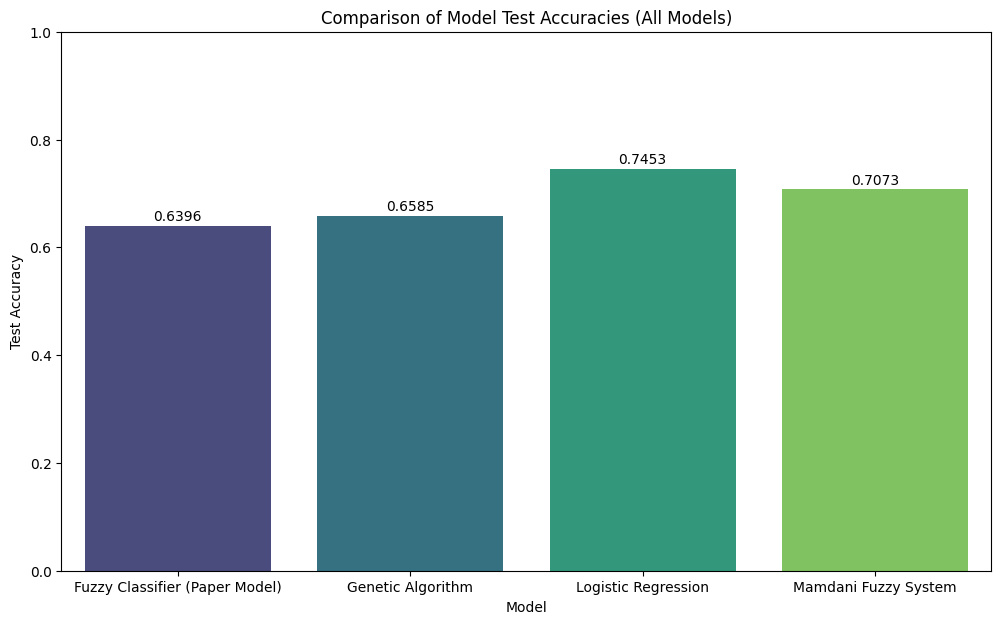

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

paper_model_accuracy = acc
genetic_algorithm_accuracy = test_acc
logistic_regression_accuracy = log_reg_accuracy
mamdani_fuzzy_accuracy = mamdani_accuracy

model_names = ['Fuzzy Classifier (Paper Model)', 'Genetic Algorithm', 'Logistic Regression', 'Mamdani Fuzzy System']
accuracies = [paper_model_accuracy, genetic_algorithm_accuracy, logistic_regression_accuracy, mamdani_fuzzy_accuracy]

comparison_df_final = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

print("\nUpdated Comparison DataFrame:")
print(comparison_df_final)

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Accuracy', hue='Model', data=comparison_df_final, palette='viridis', legend=False)
plt.title('Comparison of Model Test Accuracies (All Models)')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
for index, row in comparison_df_final.iterrows():
    plt.text(index, row['Accuracy'] + 0.01, f'{row['Accuracy']:.4f}', color='black', ha="center")

plt.show()